# Intro
In this notebook we will try to collect some data using spotify API and do a little analysis and usecase we can do from the collected data. 

# Collect Spotify Data Using Its API

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import spotipy
import spotipy.util as util
import webbrowser

from json.decoder import JSONDecodeError
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In the previous chapter, we have obtained these informations from our app : 
- `client id`
- `client secret`
- `redirect uri`

If you haven't obtained it, consider In order to use spotify APIs, you need to setup your app [here](https://developer.spotify.com/dashboard/applications) or read the previous chapter

In [2]:
SPOTIPY_CLIENT_ID = '9987feb1118f4b45ad586c8be0a02052'
SPOTIPY_CLIENT_SECRET = '8babdcaad5e145188d1c3759a67d866a'
SPOTIPY_REDIRECT_URI = 'https://www.google.com/'

## Request Types
There are two types of requests that we can do while using Spotify API, Authorized and Non Authorized request.

### Non Authorized Requests

Spotify provides several methods in its API that requires no authorizations. This means, it's open and  need no user approvals. 

To create spotify object with non authorized request, simply do the following:


In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

### Authorized Requests

<p style='text-align: justify;'>
Authorized request mean we need a user credentials to do the request. This will limit our app from accessing unnecessary informations. Spotify limiting their informations specifically to our app by creating scopes. To read more about Spotify API's Scope, please [read the documentation](https://developer.spotify.com/documentation/general/guides/scopes/). 
Scope is needed whenever we wanto to create our spotipy object.
</p>

To summarize, there are 17 Scopes, divided into 7 Major Category (per September 23th 2019): 
- Playlists
    + playlist-read-collaborative
    + playlist-modify-private
    + playlist-modify-public
    + playlist-read-private

- Spotify Connect
    + user-modify-playback-state
    + user-read-currently-playing
    + user-read-playback-state

- Users
    + user-read-private
    + user-read-email

- Library
    + user-library-modify
    + user-library-read

- Follow
    + user-follow-modify
    + user-follow-read
    
- Listening History
    + user-read-recently-played
    + user-top-read
- Playback
    + streaming
    + app-remote-control

To create spotify object with authorized requests, you need a Token based on your username. You can get your username by checking your [spotify account overview](https://www.spotify.com/id/account/overview/)

![](res/2/account_overview.png)

In [4]:
scope = 'user-library-read'
username = 'aacmjeob9bgfow15ycdudpwm3' #use your own username 

try :
    token = util.prompt_for_user_token(username, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_REDIRECT_URI)
except:
    os.remove(f".cache-{username}")
    token = util.prompt_for_user_token(username, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_REDIRECT_URI)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=9987feb1118f4b45ad586c8be0a02052&response_type=code&redirect_uri=https%3A%2F%2Fwww.google.com%2F in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQBNzS23YbospKjAeMNEn9MOU39hHemkMRQkcDBAE4DfT-MKE1vQsi-fkWB0a_hLduApiwo7bUsWbSFuI9bOMemFM72bOIdnUksm1E5yRiu5xiyOEc2bq0YjSk2uphkdrtbC0Nc5JVi6v9JtP5485r_B1Gl0gPMaQvzuJf_PB3VHPouGwOXN_TbfRQBtpHA




In [5]:
sp_auth = spotipy.Spotify(auth = token)
user = sp_auth.current_user()
print(json.dumps(user, sort_keys=True, indent=4))

{
    "display_name": "levi",
    "external_urls": {
        "spotify": "https://open.spotify.com/user/aacmjeob9bgfow15ycdudpwm3"
    },
    "followers": {
        "href": null,
        "total": 0
    },
    "href": "https://api.spotify.com/v1/users/aacmjeob9bgfow15ycdudpwm3",
    "id": "aacmjeob9bgfow15ycdudpwm3",
    "images": [],
    "type": "user",
    "uri": "spotify:user:aacmjeob9bgfow15ycdudpwm3"
}


**Notes** : Spotify token expires every one hour. Please use token refresh method refers to its [documentation](https://developer.spotify.com/documentation/general/guides/authorization-guide/#authorization-code-flow)

# Usecase : Analyze a Top Chart Playlist
In this example, we will try to get the **track's uri** on [Spotify Indonesia's Top 50](https://open.spotify.com/playlist/37i9dQZEVXbObFQZ3JLcXt). Notice that the last sequence of characters in the url is the playlist id.

![](res/2/Indonesia_top_50.PNG)

In [6]:
playlist_id = '0N5hxKlqFl6z2gVUywrdcA'

## Get all track form playlist

All the track's informations [can be read here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/)

In [7]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [8]:
playlist = get_playlist_tracks(username, playlist_id)
# print(json.dumps(playlist, sort_keys=True, indent=4))

## Get track's name

In [9]:
def get_playlist_names(playlist):
    names = []
    for _track in playlist: 
        names.append(_track['track']['name'])
    return names

In [10]:
track_names =  get_playlist_names(playlist)

## Get track's popularity
Track's popularity ranged between 0-100, and determine the popularity of track/album


In [11]:
def get_playlist_popularity(playlist):
    popularities = []
    for _track in playlist: 
        popularities.append(_track['track']['popularity'])
    return popularities

In [12]:
popularities = get_playlist_popularity(playlist)

## Get track's duration (in ms)

In [13]:
def get_playlist_duration(playlist): 
    durations = []
    for _track in playlist:
        durations.append(_track['track']['duration_ms'])
    return durations

In [15]:
durations = get_playlist_duration(playlist)

## Get track's release date

In [16]:
def get_playlist_release(playlist): 
    releases = []
    for _track in playlist:
        releases.append(_track['track']['album']['release_date'])
    return releases

In [17]:
releases = get_playlist_release(playlist)

## Get track's artists name

In [18]:
def get_artist(playlist):
    artists = []
    for _track in playlist:
        _artists = []
        for _artist in _track['track']['artists']: 
            _artists.append(_artist['name'])
        artists.append(_artists)
    
    return artists

In [19]:
artists = get_artist(playlist)

## Get all audio feature for each track

### Get track's URI

In [20]:
uris = set()
for track in playlist:
    uris.add(track['track']['uri'])

Now that we have obtained all the song's URI, let's get the track's audio Feature

### Get Track's audio feature
Described by [Spotify API Documentation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/) there are several keys that describe songs, included in data collected, called audio feature

| Key              | Value  | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|------------------|--------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| acousticness     | float  | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.                                                                                                                                                                                                                                                                                                                                                                                              |
| analysis_url     | string | An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.                                                                                                                                                                                                                                                                                                                                                                                                             |
| danceability     | float  | Danceability describes how suitable a track is for dancing based on a  combination of musical elements including tempo, rhythm stability, beat  strength, and overall regularity. A value of 0.0 is least danceable and  1.0 is most danceable.                                                                                                                                                                                                                                                                           |
| duration_ms      | int    | The duration of the track in milliseconds.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| energy           | float  | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure  of intensity and activity. Typically, energetic tracks feel fast, loud,  and noisy. For example, death metal has high energy, while a Bach  prelude scores low on the scale. Perceptual features contributing to  this attribute include dynamic range, perceived loudness, timbre, onset  rate, and general entropy.                                                                                                                            |
| id               | string | The Spotify ID for the track.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| instrumentalness | float  | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are  treated as instrumental in this context. Rap or spoken word tracks are  clearly “vocal”. The closer the instrumentalness value is to 1.0, the  greater likelihood the track contains no vocal content. Values above 0.5  are intended to represent instrumental tracks, but confidence is higher  as the value approaches 1.0.                                                                                                                   |
| key              | int    | The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.                                                                                                                                                                                                                                                                                                                                                                                           |
| liveness         | float  | Detects the presence of an audience in the recording. Higher liveness  values represent an increased probability that the track was performed  live. A value above 0.8 provides strong likelihood that the track is  live.                                                                                                                                                                                                                                                                                                |
| loudness         | float  | The overall loudness of a track in decibels (dB). Loudness values are  averaged across the entire track and are useful for comparing relative  loudness of tracks. Loudness is the quality of a sound that is the  primary psychological correlate of physical strength (amplitude). Values  typical range between -60 and 0 db.                                                                                                                                                                                          |
| mode             | int    | Mode indicates the modality (major or minor) of a track, the type of  scale from which its melodic content is derived. Major is represented by  1 and minor is 0.                                                                                                                                                                                                                                                                                                                                                         |
| speechiness      | float  | Speechiness detects the presence of spoken words in a track. The more  exclusively speech-like the recording (e.g. talk show, audio book,  poetry), the closer to 1.0 the attribute value. Values above 0.66  describe tracks that are probably made entirely of spoken words. Values  between 0.33 and 0.66 describe tracks that may contain both music and  speech, either in sections or layered, including such cases as rap  music. Values below 0.33 most likely represent music and other  non-speech-like tracks. |
| tempo            | float  | The overall estimated tempo of a track in beats per minute (BPM). In  musical terminology, tempo is the speed or pace of a given piece and  derives directly from the average beat duration.                                                                                                                                                                                                                                                                                                                              |
| time_signature   | int    | An estimated overall time signature of a track. The time signature  (meter) is a notational convention to specify how many beats are in each  bar (or measure).                                                                                                                                                                                                                                                                                                                                                           |
| track_href       | string | A link to the Web API endpoint providing full details of the track.                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| type             | string | The object type: “audio_features”                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| uri              | string | The Spotify URI for the track.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| valence          | float  | A measure from 0.0 to 1.0 describing the musical positiveness conveyed  by a track. Tracks with high valence sound more positive (e.g. happy,  cheerful, euphoric), while tracks with low valence sound more negative  (e.g. sad, depressed, angry).                                                                                                                                                                                                                                                                      |

In [21]:
af = []
for _track in tqdm(uris):
    af.append(sp_auth.audio_features(_track)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:27<00:00,  1.51it/s]


In [22]:
audio_feature = pd.DataFrame(af)
audio_feature.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.297,https://api.spotify.com/v1/audio-analysis/5p7u...,0.752,201661,0.488,5p7ujcrUXASCNwRaWNHR1C,0.000009,6,0.0936,-7.050,1,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533
1,0.119,https://api.spotify.com/v1/audio-analysis/0Ryd...,0.400,186107,0.795,0Ryd8975WihbObpp5cPW1t,0.000000,10,0.1590,-3.731,0,0.4610,190.097,4,https://api.spotify.com/v1/tracks/0Ryd8975Wihb...,audio_features,spotify:track:0Ryd8975WihbObpp5cPW1t,0.702
2,0.269,https://api.spotify.com/v1/audio-analysis/1ZLr...,0.737,192453,0.747,1ZLrDPgR7mvuTco3rQK8Pk,0.000000,10,0.2190,-4.818,1,0.0323,105.943,4,https://api.spotify.com/v1/tracks/1ZLrDPgR7mvu...,audio_features,spotify:track:1ZLrDPgR7mvuTco3rQK8Pk,0.447
3,0.164,https://api.spotify.com/v1/audio-analysis/7KRa...,0.603,231585,0.466,7KRaGWguQmNRKHVROCInCS,0.000000,3,0.1940,-4.638,0,0.0276,133.741,4,https://api.spotify.com/v1/tracks/7KRaGWguQmNR...,audio_features,spotify:track:7KRaGWguQmNRKHVROCInCS,0.313
4,0.422,https://api.spotify.com/v1/audio-analysis/3xau...,0.552,180019,0.650,3xaugmCyXrVkrDTXbFkMW3,0.000275,1,0.3720,-7.199,1,0.1280,167.788,4,https://api.spotify.com/v1/tracks/3xaugmCyXrVk...,audio_features,spotify:track:3xaugmCyXrVkrDTXbFkMW3,0.316


## Wrap it all

The previous example of collecting informations may seem confusing, so let's wrap it in a single method called `get_playlist_data` to get our track's informations

In [26]:
def get_playlist_data(username, playlist_id):
    playlist = get_playlist_tracks(username, playlist_id)
    features = [] 
    for track in tqdm(playlist):
        uri = track['track']['uri'] 
        af = sp_auth.audio_features(uri)[0]
        track_name = track['track']['name']
        popularity = track['track']['popularity']
        duration = track['track']['duration_ms']
        release_date = track['track']['album']['release_date']
        artists = []
        for _artist in track['track']['artists']: 
            artists.append(_artist['name'])
        af.update({'name':track_name, 'popularity':popularity, 'duration':duration, 'release_date':release_date, 'artists':artists})
        features.append(af)
    
    return pd.DataFrame(data=features)

In [27]:
features = get_playlist_data(username, playlist_id)


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  4.06it/s]

## Exploratory Data Analysis
Now that we already have our data, let's do the funniest part. Analysis !

In [28]:
features.head()

,acousticness,analysis_url,artists,danceability,duration,duration_ms,energy,id,instrumentalness,key,...,name,popularity,release_date,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.03700,https://api.spotify.com/v1/audio-analysis/0TK2...,"[Shawn Mendes, Camila Cabello]",0.759,190960,190960,0.540,0TK2YIli7K1leLovkQiNik,0.000000,9,...,Señorita,100,2019-06-21,0.0287,116.947,4,https://api.spotify.com/v1/tracks/0TK2YIli7K1l...,audio_features,spotify:track:0TK2YIli7K1leLovkQiNik,0.750
1,0.91100,https://api.spotify.com/v1/audio-analysis/5DuS...,[Stephanie Poetri],0.648,209734,209734,0.382,5DuSzOxHDi1qZycpzIWyhO,0.000000,6,...,I Love You 3000,62,2019-06-03,0.0396,90.099,4,https://api.spotify.com/v1/tracks/5DuSzOxHDi1q...,audio_features,spotify:track:5DuSzOxHDi1qZycpzIWyhO,0.408
2,0.11800,https://api.spotify.com/v1/audio-analysis/2ZDp...,[Rich Brian],0.756,166145,166146,0.648,2ZDpSQfBdgkooeXw6oj3Uz,0.000000,0,...,100 Degrees,78,2019-07-26,0.0731,80.979,4,https://api.spotify.com/v1/tracks/2ZDpSQfBdgko...,audio_features,spotify:track:2ZDpSQfBdgkooeXw6oj3Uz,0.657
3,0.00249,https://api.spotify.com/v1/audio-analysis/4ZGX...,[Rossy],0.432,257142,257143,0.556,4ZGXS9ZynTju8WaxHLPcLW,0.000162,9,...,it is you,36,2019-08-13,0.0282,139.756,4,https://api.spotify.com/v1/tracks/4ZGXS9ZynTju...,audio_features,spotify:track:4ZGXS9ZynTju8WaxHLPcLW,0.168
4,0.94600,https://api.spotify.com/v1/audio-analysis/2dUp...,[Lofi Radiance],0.700,197333,197333,0.208,2dUp54GW8AvsgfIkWUUcaa,0.923000,0,...,outside the window,33,2019-08-14,0.0724,90.016,4,https://api.spotify.com/v1/tracks/2dUp54GW8Avs...,audio_features,spotify:track:2dUp54GW8AvsgfIkWUUcaa,0.112


In [29]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 23 columns):
acousticness        44 non-null float64
analysis_url        44 non-null object
artists             44 non-null object
danceability        44 non-null float64
duration            44 non-null int64
duration_ms         44 non-null int64
energy              44 non-null float64
id                  44 non-null object
instrumentalness    44 non-null float64
key                 44 non-null int64
liveness            44 non-null float64
loudness            44 non-null float64
mode                44 non-null int64
name                44 non-null object
popularity          44 non-null int64
release_date        44 non-null object
speechiness         44 non-null float64
tempo               44 non-null float64
time_signature      44 non-null int64
track_href          44 non-null object
type                44 non-null object
uri                 44 non-null object
valence             44 non-null float

Note that we might not use all the variables so let's see for high possibility of useless variable, starting with a non numerical types

In [30]:
features.select_dtypes(include='object').head()

,analysis_url,artists,id,name,release_date,track_href,type,uri
0,https://api.spotify.com/v1/audio-analysis/0TK2...,"[Shawn Mendes, Camila Cabello]",0TK2YIli7K1leLovkQiNik,Señorita,2019-06-21,https://api.spotify.com/v1/tracks/0TK2YIli7K1l...,audio_features,spotify:track:0TK2YIli7K1leLovkQiNik
1,https://api.spotify.com/v1/audio-analysis/5DuS...,[Stephanie Poetri],5DuSzOxHDi1qZycpzIWyhO,I Love You 3000,2019-06-03,https://api.spotify.com/v1/tracks/5DuSzOxHDi1q...,audio_features,spotify:track:5DuSzOxHDi1qZycpzIWyhO
2,https://api.spotify.com/v1/audio-analysis/2ZDp...,[Rich Brian],2ZDpSQfBdgkooeXw6oj3Uz,100 Degrees,2019-07-26,https://api.spotify.com/v1/tracks/2ZDpSQfBdgko...,audio_features,spotify:track:2ZDpSQfBdgkooeXw6oj3Uz
3,https://api.spotify.com/v1/audio-analysis/4ZGX...,[Rossy],4ZGXS9ZynTju8WaxHLPcLW,it is you,2019-08-13,https://api.spotify.com/v1/tracks/4ZGXS9ZynTju...,audio_features,spotify:track:4ZGXS9ZynTju8WaxHLPcLW
4,https://api.spotify.com/v1/audio-analysis/2dUp...,[Lofi Radiance],2dUp54GW8AvsgfIkWUUcaa,outside the window,2019-08-14,https://api.spotify.com/v1/tracks/2dUp54GW8Avs...,audio_features,spotify:track:2dUp54GW8AvsgfIkWUUcaa


In [31]:
features.select_dtypes(include='object').describe()

,analysis_url,artists,id,name,release_date,track_href,type,uri
count,44,44,44,44,44,44,44,44
unique,44,42,44,44,38,44,1,44
top,https://api.spotify.com/v1/audio-analysis/79Kw...,[Ariana Grande],6vBdBCoOhKHiYDDOcorfNo,100 Degrees,2019-06-14,https://api.spotify.com/v1/tracks/6wo37KVqFJht...,audio_features,spotify:track:322tcqPhma7F6hfCeLisx0
freq,1,2,1,1,2,1,44,1


From the table showed above, `analysis_url`, `id`, `track_href`, and `uri` works as unique identifier and stores no implicit values. So it is unnecessary for us to include those variables into account. As for `type` variable, it only stores value of "audio_feature". Thus, it's not necessary to be analyzed.
for now, let's drop `analysis_url`, `id`, `track_href`,`uri`, and `type`

In [32]:
clean_af = features.drop(columns=['analysis_url', 'id', 'track_href', 'uri', 'type'])
clean_af.head()

,acousticness,artists,danceability,duration,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,time_signature,valence
0,0.03700,"[Shawn Mendes, Camila Cabello]",0.759,190960,190960,0.540,0.000000,9,0.0945,-6.039,0,Señorita,100,2019-06-21,0.0287,116.947,4,0.750
1,0.91100,[Stephanie Poetri],0.648,209734,209734,0.382,0.000000,6,0.3930,-7.850,1,I Love You 3000,62,2019-06-03,0.0396,90.099,4,0.408
2,0.11800,[Rich Brian],0.756,166145,166146,0.648,0.000000,0,0.5150,-5.287,1,100 Degrees,78,2019-07-26,0.0731,80.979,4,0.657
3,0.00249,[Rossy],0.432,257142,257143,0.556,0.000162,9,0.2320,-7.415,0,it is you,36,2019-08-13,0.0282,139.756,4,0.168
4,0.94600,[Lofi Radiance],0.700,197333,197333,0.208,0.923000,0,0.0854,-11.410,1,outside the window,33,2019-08-14,0.0724,90.016,4,0.112


If you notice that there are 2 columns telling us about durations, called "duration" and "duration_ms". Where did they comes ? the `duration` came from our outer information while getting track's data from playlist. While `duration_ms` came from audio_feature that we get from specific tracks. These two features should have the same meaning. Now let's check whether they're the same

In [33]:
clean_af.duration == clean_af.duration_ms

0      True
1      True
2     False
3     False
4      True
5     False
6      True
7     False
8     False
9      True
10    False
11     True
12    False
13    False
14    False
15     True
16    False
17    False
18    False
19     True
20     True
21    False
22     True
23    False
24     True
25     True
26    False
27     True
28     True
29     True
30    False
31     True
32    False
33     True
34    False
35    False
36    False
37    False
38     True
39     True
40     True
41     True
42     True
43    False
dtype: bool

In [34]:
abs(clean_af.duration - clean_af.duration_ms).mean()

0.5

The average error between the two variables are only 0.5 ms. It's not a significant values, so let's just randomly drop one of them.

In [35]:
clean_af.drop(columns=['duration_ms'], inplace=True)
clean_af

,acousticness,artists,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,time_signature,valence
0,0.03700,"[Shawn Mendes, Camila Cabello]",0.759,190960,0.540,0.000000,9,0.0945,-6.039,0,Señorita,100,2019-06-21,0.0287,116.947,4,0.750
1,0.91100,[Stephanie Poetri],0.648,209734,0.382,0.000000,6,0.3930,-7.850,1,I Love You 3000,62,2019-06-03,0.0396,90.099,4,0.408
2,0.11800,[Rich Brian],0.756,166145,0.648,0.000000,0,0.5150,-5.287,1,100 Degrees,78,2019-07-26,0.0731,80.979,4,0.657
3,0.00249,[Rossy],0.432,257142,0.556,0.000162,9,0.2320,-7.415,0,it is you,36,2019-08-13,0.0282,139.756,4,0.168
4,0.94600,[Lofi Radiance],0.700,197333,0.208,0.923000,0,0.0854,-11.410,1,outside the window,33,2019-08-14,0.0724,90.016,4,0.112
5,0.09120,"[Ed Sheeran, Justin Bieber]",0.798,219946,0.675,0.000000,6,0.0894,-5.041,1,I Don't Care (with Justin Bieber),94,2019-05-10,0.0442,101.956,4,0.842
6,0.93300,[Andmesh],0.294,251056,0.146,0.000044,7,0.1300,-13.090,1,Hanya Rindu,76,2019-04-26,0.0336,177.658,3,0.299
7,0.89100,[Budi Doremi],0.435,250322,0.200,0.000000,9,0.1030,-12.481,1,Tolong,75,2018-10-30,0.0365,136.054,4,0.244
8,0.72700,[Andmesh],0.590,255624,0.263,0.000000,9,0.1170,-10.006,1,Cinta Luar Biasa,76,2018-11-02,0.0283,135.927,4,0.325
9,0.05750,"[ZAYN, Zhavia Ward]",0.302,242956,0.414,0.000000,2,0.0861,-8.160,1,"A Whole New World (End Title) - From ""Aladdin""",81,2019-05-09,0.0319,110.508,4,0.105


In [36]:
clean_af.select_dtypes(exclude='object').describe()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.398449,0.596682,214124.590909,0.507318,0.029227,5.068182,0.167620,-7.415841,0.704545,76.318182,0.074184,117.710477,3.931818,0.414205
std,0.291587,0.149656,36057.836175,0.178925,0.146612,3.656137,0.123528,2.621139,0.461522,15.530574,0.086101,28.429905,0.501056,0.212059
min,0.002490,0.294000,156346.000000,0.146000,0.000000,0.000000,0.059600,-13.090000,0.000000,33.000000,0.026700,70.142000,1.000000,0.105000
25%,0.119750,0.478500,190920.000000,0.380000,0.000000,1.750000,0.096900,-8.260500,0.000000,70.000000,0.032200,94.753750,4.000000,0.241000
50%,0.427000,0.623500,204942.000000,0.514000,0.000000,5.000000,0.117500,-7.281500,1.000000,78.000000,0.044050,117.424000,4.000000,0.351000
75%,0.598750,0.724250,234427.750000,0.648500,0.000000,9.000000,0.189750,-5.056750,1.000000,87.250000,0.070975,135.273000,4.000000,0.562750
max,0.946000,0.806000,313670.000000,0.862000,0.923000,11.000000,0.637000,-3.731000,1.000000,100.000000,0.461000,190.097000,5.000000,0.864000


non normalized data :
    - durations ( 0 to infinity)
    - key ( 0 to 12, based on its documentation)
    - loudness (-60 to 0)
    - popularity (0 to 100)
    - tempo (0 to infinity)
    - time_signature (3 to 7, denoting number beat per bar, 3/7 to 7/7)
    


Since we have a standard scale, we can normalize key, loudness, popularity, and time_signature easiliy while keeping its interpretability. As for durations and tempo, there is no such a scale limiting their value so we will normalize them based on the data (using minimum and maximum values). Why do we need to scale or standardize ? [this blog post](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02) give a brief introduction of why you should do that.

These equation may help you summarize the process of normalied value (denoted by $z$)

$$ z = \frac{x - min(x)}{max(x) - min(x)}$$

$$ x = z * (max(x) - min(x))  + min(x)$$

In [37]:
class SpNormalizer():
    def __init__(self, feature):
        self.min_val = feature.min()
        self.max_val = feature.max()
        self.mean_val = feature.mean()
        
        self.norm_cols = ['duration', 'key','loudness', 'popularity', 'tempo', 'time_signature']
        
        self.min_val[['duration', 'key','loudness', 'popularity', 'tempo', 'time_signature']] = [0,0,-60,0,0,3]
        self.max_val[['key','loudness', 'popularity', 'time_signature']] = [12,0,100,7]
        
    def scale(self, feature):
        _feature = feature.copy()
        for col in self.norm_cols:
            _feature[col] = _feature[col].apply(lambda x : (x - self.min_val[col])/(self.max_val[col] - self.min_val[col]))
        return _feature

    
    def descale(self, feature):
        _feature = feature.copy()
        
        for col in self.norm_cols:
            _feature[col] = _feature[col].apply(lambda x : x *(self.max_val[col] - self.min_val[col]) + self.min_val[col])
        return _feature

To make sure that our normalizer works well, let's try to normalize and then denormalize them.

In [38]:
a = clean_af.copy()
spnorm = SpNormalizer(a)
a2 = spnorm.scale(a)
a3 = spnorm.descale(a2)

In [39]:
a2.head()

,acousticness,artists,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,time_signature,valence
0,0.03700,"[Shawn Mendes, Camila Cabello]",0.759,0.608793,0.540,0.000000,0.75,0.0945,0.899350,0,Señorita,1.00,2019-06-21,0.0287,0.615196,0.25,0.750
1,0.91100,[Stephanie Poetri],0.648,0.668645,0.382,0.000000,0.50,0.3930,0.869167,1,I Love You 3000,0.62,2019-06-03,0.0396,0.473963,0.25,0.408
2,0.11800,[Rich Brian],0.756,0.529681,0.648,0.000000,0.00,0.5150,0.911883,1,100 Degrees,0.78,2019-07-26,0.0731,0.425988,0.25,0.657
3,0.00249,[Rossy],0.432,0.819785,0.556,0.000162,0.75,0.2320,0.876417,0,it is you,0.36,2019-08-13,0.0282,0.735183,0.25,0.168
4,0.94600,[Lofi Radiance],0.700,0.629110,0.208,0.923000,0.00,0.0854,0.809833,1,outside the window,0.33,2019-08-14,0.0724,0.473527,0.25,0.112


In [40]:
a3.head()

,acousticness,artists,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,time_signature,valence
0,0.03700,"[Shawn Mendes, Camila Cabello]",0.759,190960.0,0.540,0.000000,9.0,0.0945,-6.039,0,Señorita,100.0,2019-06-21,0.0287,116.947,4.0,0.750
1,0.91100,[Stephanie Poetri],0.648,209734.0,0.382,0.000000,6.0,0.3930,-7.850,1,I Love You 3000,62.0,2019-06-03,0.0396,90.099,4.0,0.408
2,0.11800,[Rich Brian],0.756,166145.0,0.648,0.000000,0.0,0.5150,-5.287,1,100 Degrees,78.0,2019-07-26,0.0731,80.979,4.0,0.657
3,0.00249,[Rossy],0.432,257142.0,0.556,0.000162,9.0,0.2320,-7.415,0,it is you,36.0,2019-08-13,0.0282,139.756,4.0,0.168
4,0.94600,[Lofi Radiance],0.700,197333.0,0.208,0.923000,0.0,0.0854,-11.410,1,outside the window,33.0,2019-08-14,0.0724,90.016,4.0,0.112


In [41]:
a.head()

,acousticness,artists,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,time_signature,valence
0,0.03700,"[Shawn Mendes, Camila Cabello]",0.759,190960,0.540,0.000000,9,0.0945,-6.039,0,Señorita,100,2019-06-21,0.0287,116.947,4,0.750
1,0.91100,[Stephanie Poetri],0.648,209734,0.382,0.000000,6,0.3930,-7.850,1,I Love You 3000,62,2019-06-03,0.0396,90.099,4,0.408
2,0.11800,[Rich Brian],0.756,166145,0.648,0.000000,0,0.5150,-5.287,1,100 Degrees,78,2019-07-26,0.0731,80.979,4,0.657
3,0.00249,[Rossy],0.432,257142,0.556,0.000162,9,0.2320,-7.415,0,it is you,36,2019-08-13,0.0282,139.756,4,0.168
4,0.94600,[Lofi Radiance],0.700,197333,0.208,0.923000,0,0.0854,-11.410,1,outside the window,33,2019-08-14,0.0724,90.016,4,0.112


As you can see, there is no such a different between a and a3. But, even it looks the same, there are a slightly different in the decimal value (so little that you may not see them). This can be look if we compare the value using logical operator. Again, this differences is so litle that it won't affect the interpretation of the value

In [42]:
(a == a3).head()

,acousticness,artists,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,time_signature,valence
0,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True
2,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True
4,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True


### Artist with most appearance

to get all the artist list, first we have to unlist our artist's lists

In [43]:
clean_af['artists'].head()

0    [Shawn Mendes, Camila Cabello]
1                [Stephanie Poetri]
2                      [Rich Brian]
3                           [Rossy]
4                   [Lofi Radiance]
Name: artists, dtype: object

In [44]:
_artist = []
for artists in clean_af['artists']: 
    for i in artists:
        _artist.append(i)
_artist = pd.Series(_artist)
artist_count = _artist.value_counts()
artist_count.head(5)

Ariana Grande    3
Shawn Mendes     2
Alan Walker      2
Justin Bieber    2
Marion Jola      2
dtype: int64

In [45]:
artist_count.describe()

count    59.000000
mean      1.169492
std       0.421514
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
dtype: float64

In [46]:
import plotly.graph_objects as go

labels = artist_count.index
values = artist_count.values

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.63)])
fig.show()

From the data we can learn that artist with most occurences are "Ariana Grande", then followed by "Shawn Mendes", "Justin Bieber", "Marion Jola", and many others. Most of them only appeared once.

**Note: The list may differs each time you run this, since the playlist keep getting updated**

### Music Preferences Comparrison

In this example, I will compare Indonesia's and Singapore's top chart's on spotify. These two playlist can be accessed in [here (Indonesia's)](https://open.spotify.com/playlist/0N5hxKlqFl6z2gVUywrdcA) and [here (Singapore's)](https://open.spotify.com/playlist/0cEPt12i4kitOqVLmyem8d)

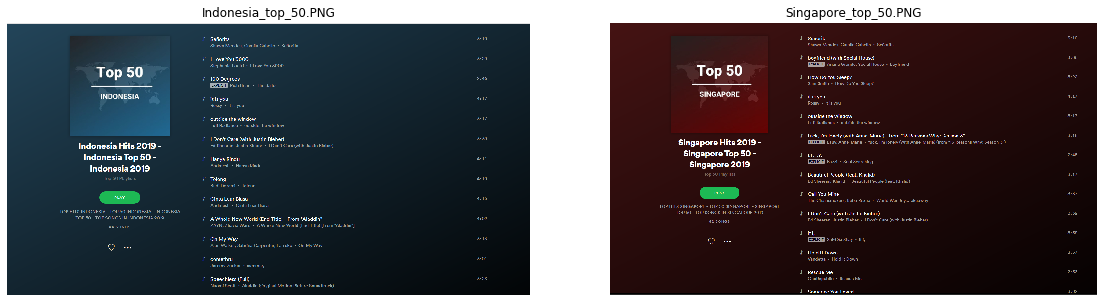

In [47]:
import matplotlib.image as mpimg
img_names = ['Indonesia_top_50.PNG', 'Singapore_top_50.PNG']
img = []
for i in img_names:
    img.append(mpimg.imread('res/2/'+i))
fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(len(img)):
        ax[i].imshow(img[i])
        ax[i].set_title(img_names[i])
        ax[i].axis('off')
plt.show()

In [48]:
playlist_id = '0N5hxKlqFl6z2gVUywrdcA'
playlist_sg = '0cEPt12i4kitOqVLmyem8d'

In [49]:
features_id = get_playlist_data(username, playlist_id)


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:27<00:00,  1.53it/s]

In [50]:
features_sg = get_playlist_data(username, playlist_sg)


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:24<00:00,  2.34it/s]

We want to normalize them, so first let's combine the two dataframe. In order to keep them separated, let's create a new column called `location` filled with 'Indonesia' or 'Singapore'

In [51]:
features_id['location'] = ['Indonesia']*features_id.shape[0]
features_sg['location'] = ['Singapore']*features_sg.shape[0]

In [52]:
features_c = features_id.append(features_sg).reset_index(drop=True)
features_c.tail()

,acousticness,analysis_url,artists,danceability,duration,duration_ms,energy,id,instrumentalness,key,...,popularity,release_date,speechiness,tempo,time_signature,track_href,type,uri,valence,location
91,0.0427,https://api.spotify.com/v1/audio-analysis/4y3O...,[Jonas Brothers],0.842,181040,181040,0.734,4y3OI86AEP6PQoDE6olYhO,0.000000,1,...,87,2019-03-01,0.0588,137.958,4,https://api.spotify.com/v1/tracks/4y3OI86AEP6P...,audio_features,spotify:track:4y3OI86AEP6PQoDE6olYhO,0.952,Singapore
92,0.3150,https://api.spotify.com/v1/audio-analysis/76D5...,[brb.],0.816,147891,147892,0.529,76D536xRk0FNg9kGPBxgdX,0.000002,8,...,49,2019-06-07,0.2140,92.522,4,https://api.spotify.com/v1/tracks/76D536xRk0FN...,audio_features,spotify:track:76D536xRk0FNg9kGPBxgdX,0.821,Singapore
93,0.4220,https://api.spotify.com/v1/audio-analysis/3xau...,[Joji],0.552,180018,180019,0.650,3xaugmCyXrVkrDTXbFkMW3,0.000275,1,...,83,2019-06-14,0.1280,167.788,4,https://api.spotify.com/v1/tracks/3xaugmCyXrVk...,audio_features,spotify:track:3xaugmCyXrVkrDTXbFkMW3,0.316,Singapore
94,0.5050,https://api.spotify.com/v1/audio-analysis/6I5e...,"[Jon Chua JX, FLANNEL ALBERT]",0.682,182500,182500,0.532,6I5e8RRQWXaYLw8iwWDxN2,0.000000,4,...,41,2019-07-26,0.0391,95.981,4,https://api.spotify.com/v1/tracks/6I5e8RRQWXaY...,audio_features,spotify:track:6I5e8RRQWXaYLw8iwWDxN2,0.469,Singapore
95,0.0706,https://api.spotify.com/v1/audio-analysis/7JCi...,[CHUNG HA],0.751,213164,213164,0.726,7JCi89HGiURxFpr6NITY7q,0.000003,8,...,75,2019-06-24,0.0380,104.914,4,https://api.spotify.com/v1/tracks/7JCi89HGiURx...,audio_features,spotify:track:7JCi89HGiURxFpr6NITY7q,0.581,Singapore


In [53]:
# drop unnecessary feature 
features_c.drop(columns=['analysis_url', 'id', 'track_href', 'uri', 'type', 'duration_ms'], inplace=True)

In [54]:
# fit and transform to rescale features value 
spnorm = SpNormalizer(features_c)
features_cn = spnorm.scale(features_c)

In [55]:
features_c.select_dtypes(exclude='object').mean()

acousticness             0.320100
danceability             0.621625
duration            202342.875000
energy                   0.572635
instrumentalness         0.026520
key                      5.312500
liveness                 0.168669
loudness                -6.863698
mode                     0.645833
popularity              75.218750
speechiness              0.083392
tempo                  119.335792
time_signature           3.937500
valence                  0.459906
dtype: float64

In [56]:
features_cn.select_dtypes(exclude='object').mean()

acousticness        0.320100
danceability        0.621625
duration            0.645082
energy              0.572635
instrumentalness    0.026520
key                 0.442708
liveness            0.168669
loudness            0.885605
mode                0.645833
popularity          0.752188
speechiness         0.083392
tempo               0.627763
time_signature      0.234375
valence             0.459906
dtype: float64

In [57]:
features_id = features_cn [features_cn['location'] == 'Indonesia']
features_sg = features_cn [features_cn['location'] == 'Singapore']

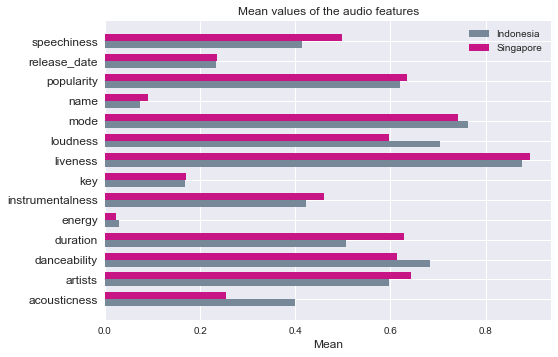

In [59]:
N = len(features_cn.mean())
ind = np.arange(N) 

width = 0.35  
plt.barh(ind, features_id.mean() , width, label='Indonesia', color = 'lightslategray')
plt.barh(ind + width, features_sg.mean(), width, label='Singapore', color = 'mediumvioletred')

plt.xlabel('Mean', fontsize = 12)
plt.title('Mean values of the audio features')
plt.yticks(ind + width / 2, (list(features_sg)[:]), fontsize = 12)
plt.legend(loc='best')
plt.rcParams['figure.figsize'] =(8,8)
style.use("seaborn")
plt.show()


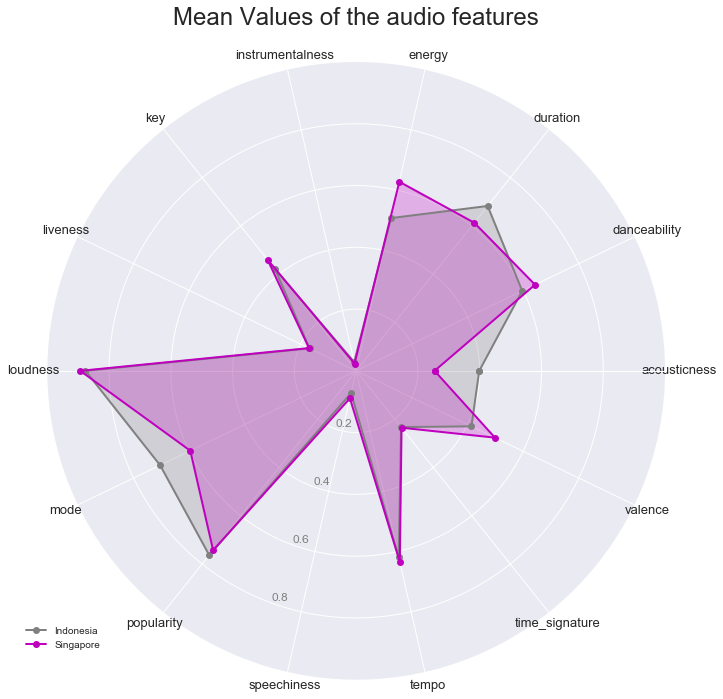

In [60]:
labels= list(features_id.select_dtypes(exclude='object').columns)
stats= features_id.mean().tolist()
stats2 = features_sg.mean().tolist()

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

stats = np.concatenate((stats,[stats[0]]))
stats2 = np.concatenate((stats2,[stats2[0]])) 
angles = np.concatenate((angles,[angles[0]]))

fig = plt.figure(figsize = (25,25))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, label = "Indonesia", color= 'gray')
ax.fill(angles, stats, alpha=0.25, facecolor='gray')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)

ax.set_rlabel_position(250)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ["0.2",'0.4', "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

ax.plot(angles, stats2, 'o-', linewidth=2, label = "Singapore", color = 'm')
ax.fill(angles, stats2, alpha=0.25, facecolor='m' )
ax.set_title('Mean Values of the audio features', size=24)
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

<p style='text-align: justify;'>
Based on the graph, there are no big different between Indonesia's and Singapore's audio features. The biggest differences may occur in `mode`, `accousticness`, and `energy`. 

Indonesia tend to listens to music with higher mode that Singapore. Higher mode means Major scales on the music, and lower mode means Minor scales. This could indicate the theme of the music, wether it is sad or happy. In sort, Indonesia listens more happy music than Singapore.

High value in accoustic means the music is more accoustic. The graph shows that Indonesia listen to low accoustic music, but Singapore much lower. Energy means intensity or activity of the music. Indonesia have higher value of energy than Singapore. This could inference that Indonesia have a more intense music flavor than Singapore.

</p>

# Conclusion

Spotify API gives us many access to the data, and enlarge the opportunities for data scientist to gain insight or create predictive models in the future.

Our next step is to do a machine learning approach from the collected data.